In [9]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Tải tập Training và Test
try:
    df_train = pd.read_csv('./input/train.csv')
    df_test = pd.read_csv('./input/test.csv')
    print("Tải dữ liệu thành công!")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file train.csv hoặc test.csv.")
    exit()

# 1. Lưu lại Id và biến mục tiêu (Class)
train_id = df_train['Id']
test_id = df_test['Id']
y = df_train['Class'] 

# 2. Loại bỏ cột Id và Class khỏi tập dữ liệu
df_train = df_train.drop(['Id', 'Class'], axis=1)
df_test = df_test.drop('Id', axis=1)

# 3. Hợp nhất tập Train và Test để tiền xử lý đồng nhất
df_combined = pd.concat([df_train, df_test], ignore_index=True)

print(f"Kích thước tập hợp nhất: {df_combined.shape}")

Tải dữ liệu thành công!
Kích thước tập hợp nhất: (17996, 16)


In [10]:
# Kỹ thuật Đặc trưng - Sửa lỗi Đơn vị duration_in min/ms
def correct_duration(df):
    """Chuẩn hóa đơn vị duration_in min/ms thành mili giây (ms)."""
    df_temp = df.copy() 
    
    DURATION_THRESHOLD = 1000 # Giả định các giá trị nhỏ hơn 1000 là phút
    MS_PER_MINUTE = 60000
    
    is_in_minutes = df_temp['duration_in min/ms'] < DURATION_THRESHOLD
    
    # Chuyển đổi các giá trị tính bằng phút sang mili giây
    df_temp.loc[is_in_minutes, 'duration_in min/ms'] *= MS_PER_MINUTE
    
    df_temp = df_temp.rename(columns={'duration_in min/ms': 'duration_ms'})
    
    return df_temp

df_combined = correct_duration(df_combined)

print("Đã hoàn thành chuẩn hóa đơn vị duration_ms.")
print(df_combined['duration_ms'].describe())

Đã hoàn thành chuẩn hóa đơn vị duration_ms.
count    1.799600e+04
mean     2.358233e+05
std      8.567503e+04
min      2.332000e+04
25%      1.876497e+05
50%      2.200000e+05
75%      2.630822e+05
max      1.793160e+06
Name: duration_ms, dtype: float64


### 1. Phân tích Imputation và Kỹ thuật Đặc trưng

**Mục tiêu:** Giải quyết các vấn đề về giá trị thiếu (Missing Values) và đơn vị không nhất quán (Unit Inconsistency) đã được phát hiện trong EDA.

#### A. Sửa lỗi Đơn vị `duration_in min/ms`
- **Vấn đề:** Cột này chứa dữ liệu hỗn hợp: phần lớn là **mili giây (ms)** nhưng có một số giá trị nhỏ (dưới 1000) có vẻ là **phút**.
- **Hành động:** Chúng tôi đã chuyển đổi tất cả các giá trị nhỏ hơn 1000 thành mili giây bằng cách nhân với 60,000, sau đó đổi tên cột thành **`duration_ms`** để thống nhất đơn vị.

#### B. Xử lý Cột Object (Văn bản)
- **Cột:** `Artist Name`, `Track Name`.
- **Hành động:** Do số lượng giá trị độc nhất (Cardinality) quá cao, các cột này đã được **loại bỏ** trong `ColumnTransformer` (Cell 4) vì chúng gây phức tạp cho mô hình phân loại và ít có khả năng đóng góp thông tin quan trọng hơn các đặc trưng âm thanh.

#### C. Chiến lược Imputation (Xử lý Giá trị Thiếu)
- **Cột Số học (liên tục):** (`Popularity`, `instrumentalness`, v.v.) được điền bằng **Median (Trung vị)**. Median được ưu tiên hơn Mean vì nó ít bị ảnh hưởng bởi các giá trị ngoại lai.
- **Cột Phân loại (`key`, `time_signature`):** Được điền bằng **Most Frequent (Mode)**, vì Imputer cần xử lý Missing Values trước khi `OneHotEncoder` mã hóa chúng.

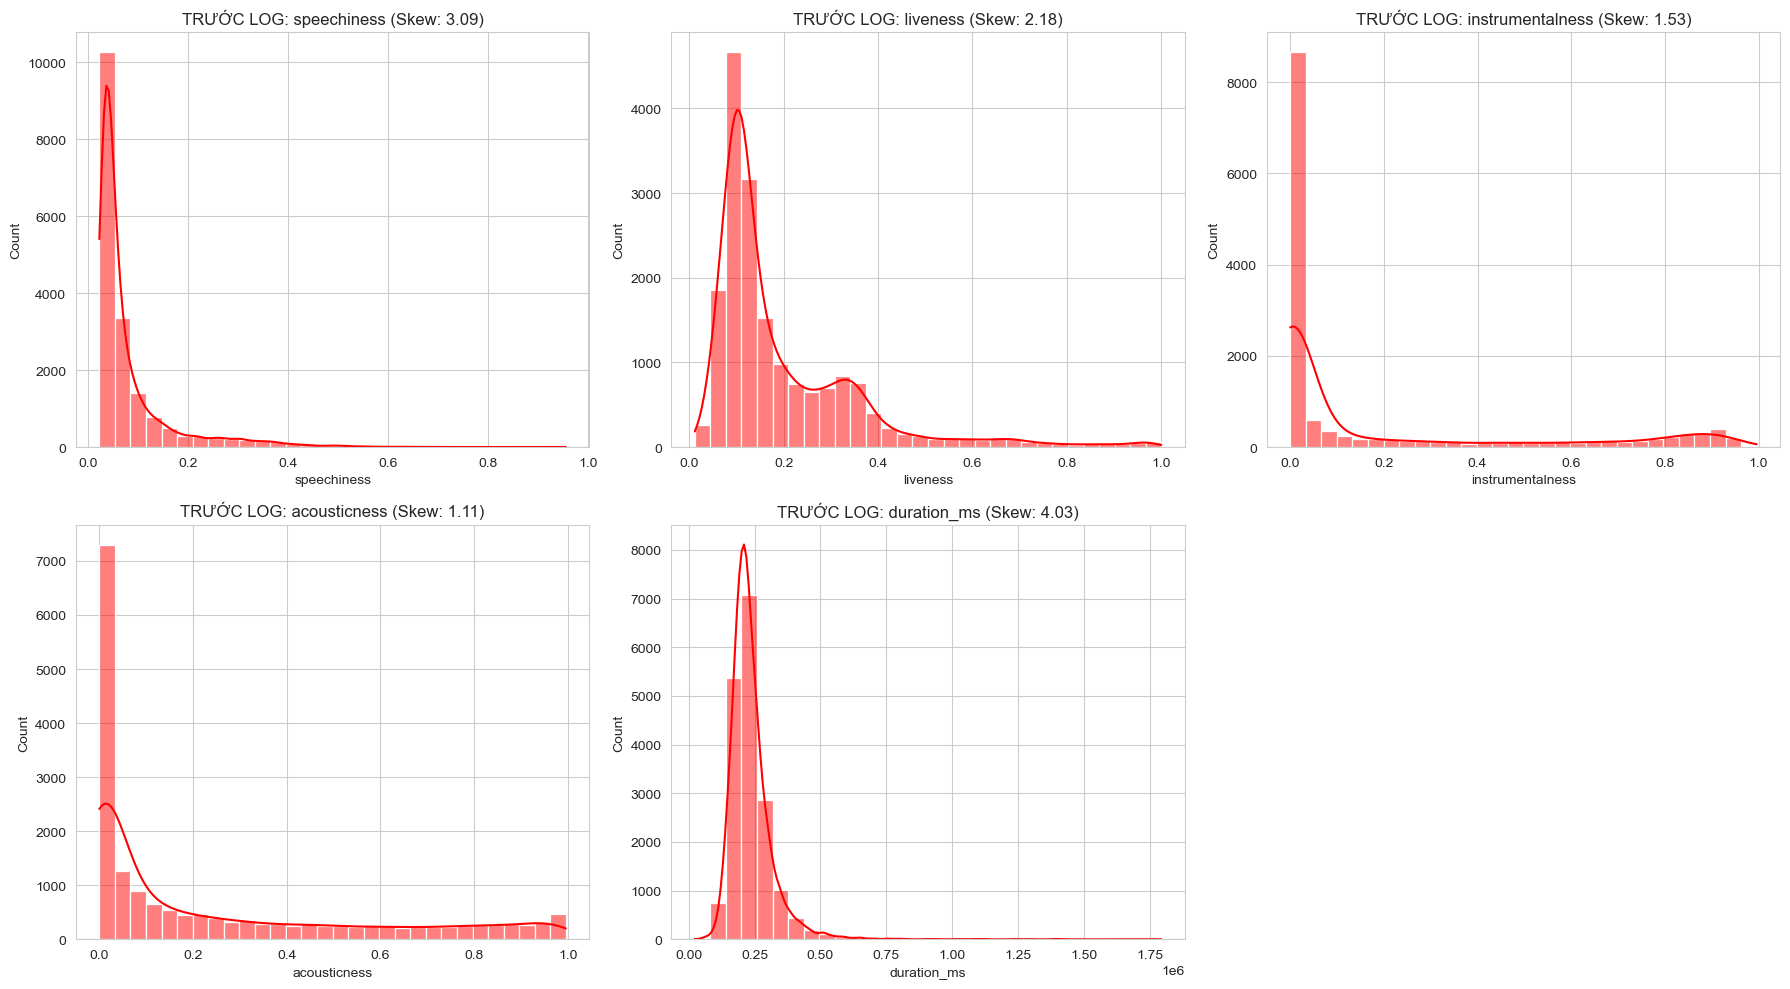

In [11]:
# Trực quan hóa Phân phối Lệch (Trước Biến đổi Log)
SKEWED_COLS = ['speechiness', 'liveness', 'instrumentalness', 'acousticness', 'duration_ms']

plt.figure(figsize=(18, 10)) 
for i, col in enumerate(SKEWED_COLS):
    plt.subplot(2, 3, i + 1)
    # Lọc bỏ NaN cho trực quan (Imputer sẽ xử lý sau)
    sns.histplot(df_combined[col].dropna(), kde=True, bins=30, color='red') 
    plt.title(f'TRƯỚC LOG: {col} (Skew: {df_combined[col].skew():.2f})', fontsize=12)
    plt.xlabel(col, fontsize=10)
    
plt.tight_layout()
plt.savefig('./doc/fig/distribution_before_log.png')
plt.show()

### 2. Trực quan hóa Phân phối TRƯỚC Biến đổi Log

Biểu đồ **Histograms TRƯỚC LOG** (Cell 3, `distribution_before_log.png`) cho thấy rõ ràng vấn đề **Độ nghiêng dương (Positive Skewness)** của các đặc trưng chính:

- **Các cột nghiêng mạnh:** `speechiness`, `liveness`, `instrumentalness`, `acousticness`.
- **Đặc điểm:** Phân phối của chúng tập trung rất nhiều ở gần 0, sau đó kéo dài thành một "đuôi" dài về phía dương. Điều này có nghĩa là đa số các bản nhạc có giá trị thấp cho các đặc trưng này (ví dụ: ít giọng nói, ít độ trực tiếp, ít âm thanh acoustic).


In [12]:
# Cell 4: Định nghĩa Pipelines và ColumnTransformer 

# 1. Định nghĩa các nhóm cột (Không thay đổi)
LOG_SCALED_COLS = ['speechiness', 'liveness', 'instrumentalness', 'acousticness', 'duration_ms']
OTHER_NUMERICAL_COLS = ['Popularity', 'danceability', 'energy', 'loudness', 'valence', 'tempo']
CATEGORICAL_COLS = ['key', 'mode', 'time_signature']
TEXT_COLS = ['Artist Name', 'Track Name']

# 2. Pipeline cho các cột cần Log Transform và Scaling
log_scaled_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    
    # SỬA LỖI: Thêm feature_names_out='one-to-one' vào FunctionTransformer
    ('log_transform', FunctionTransformer(np.log1p, validate=True, feature_names_out='one-to-one')), 
    
    ('scaler', StandardScaler())
])

# 3. Pipeline cho các cột Số học khác (Không thay đổi)
other_numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 4. Pipeline cho các cột Phân loại (Không thay đổi)
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

# 5. ColumnTransformer (Không thay đổi)
preprocessor = ColumnTransformer(
    transformers=[
        ('log_num', log_scaled_pipeline, LOG_SCALED_COLS),
        ('other_num', other_numerical_pipeline, OTHER_NUMERICAL_COLS),
        ('cat', categorical_pipeline, CATEGORICAL_COLS),
        ('drop_text', 'drop', TEXT_COLS)
    ],
    remainder='drop' 
)

print("Đã thiết lập ColumnTransformer hoàn chỉnh với sửa lỗi FunctionTransformer.")

Đã thiết lập ColumnTransformer hoàn chỉnh với sửa lỗi FunctionTransformer.


### 3. Cấu trúc Pipelines và ColumnTransformer

Chúng tôi sử dụng **Scikit-learn Pipelines** và **ColumnTransformer** để đảm bảo tính nhất quán và khả năng tái sử dụng (reproducibility) của quá trình tiền xử lý trên cả tập Train và Test.

- **ColumnTransformer** chia dữ liệu thành các nhóm để áp dụng các phép biến đổi khác nhau:

| Tên Transformer | Cột áp dụng | Các bước trong Pipeline | Mục tiêu |
|:---|:---|:---|:---|
| `log_num` | `speechiness`, `liveness`, `instrumentalness`, `acousticness`, `duration_ms` | Impute (Median) $\rightarrow$ **Log Transform** $\rightarrow$ StandardScaler | Giảm Skewness và Chuẩn hóa. |
| `other_num` | `Popularity`, `energy`, `loudness`, v.v. | Impute (Median) $\rightarrow$ **StandardScaler** | Chuẩn hóa mà không cần Log Transform. |
| `cat` | `key`, `mode`, `time_signature` | Impute (Mode) $\rightarrow$ **OneHotEncoder** | Mã hóa các biến phân loại thành dạng nhị phân. |
| `drop_text` | `Artist Name`, `Track Name` | `drop` | Loại bỏ các cột không cần thiết. |


In [17]:
# Cell 5: Áp dụng Transform, Tách Dữ liệu VÀ LƯU TRỮ

# Áp dụng Transform
print("Bắt đầu quá trình Transform...")
X_processed = preprocessor.fit_transform(df_combined) 
print("Transform hoàn tất.")

# Lấy tên cột chính xác từ preprocessor
feature_names_out = preprocessor.get_feature_names_out()

# Chuyển đổi ma trận kết quả thành DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=feature_names_out)

# Tách dữ liệu trở lại thành Train và Test
X_train_processed = X_processed_df[:len(df_train)]
X_test_processed = X_processed_df[len(df_train):]

# Kiểm tra kích thước cuối cùng
print(f"\nKích thước tập Train đã xử lý: {X_train_processed.shape}")
print(f"Kích thước tập Test đã xử lý: {X_test_processed.shape}")

# ==========================================================
# PHẦN MỚI: LƯU TRỮ DỮ LIỆU ĐÃ XỬ LÝ
# ==========================================================

# Lưu X_train_processed
X_train_processed.to_csv('./input/process/X_train_processed.csv', index=False)
print("Đã lưu X_train_processed.csv")

# Lưu X_test_processed
X_test_processed.to_csv('./input/process/X_test_processed.csv', index=False)
print("Đã lưu X_test_processed.csv")

# Lưu biến mục tiêu y (cần phải reset index để khớp với X_train_processed)
pd.DataFrame({'Class': y.values}).to_csv('./input/process/y_train.csv', index=False)
print("Đã lưu y_train.csv")

print("\n--- 5 Hàng đầu tiên của Tập Train đã xử lý ---")
display(X_train_processed.head())

Bắt đầu quá trình Transform...
Transform hoàn tất.

Kích thước tập Train đã xử lý: (14396, 28)
Kích thước tập Test đã xử lý: (3600, 28)
Đã lưu X_train_processed.csv
Đã lưu X_test_processed.csv
Đã lưu y_train.csv

--- 5 Hàng đầu tiên của Tập Train đã xử lý ---


,log_num__speechiness,log_num__liveness,log_num__instrumentalness,log_num__acousticness,log_num__duration_ms,other_num__Popularity,other_num__danceability,other_num__energy,other_num__loudness,other_num__valence,other_num__tempo,cat__key_1.0,cat__key_2.0,cat__key_3.0,cat__key_4.0,cat__key_5.0,cat__key_6.0,cat__key_7.0,cat__key_8.0,cat__key_9.0,cat__key_10.0,cat__key_11.0,cat__mode_0.0,cat__mode_1.0,cat__time_signature_1.0,cat__time_signature_3.0,cat__time_signature_4.0,cat__time_signature_5.0
0,-0.522963,-0.593190,-0.495117,0.561386,-0.305991,-0.435584,-1.259644,-0.538635,0.311595,-1.045880,1.007947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.141245,-0.608366,-0.287955,-0.735678,-0.524201,1.306765,1.092040,0.357838,0.584252,-0.442188,0.348240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.199743,0.658091,1.920087,-0.849886,-1.109439,-0.029036,0.243990,0.600013,0.448664,0.619478,1.262388,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.618056,0.761930,-0.410075,1.995759,0.942428,-1.887542,-0.171013,-1.507335,-1.679495,0.061583,1.685746,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,2.114276,0.167291,-0.495117,-0.112228,0.410941,0.203277,0.129714,0.485299,0.695143,0.552864,-1.160347,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


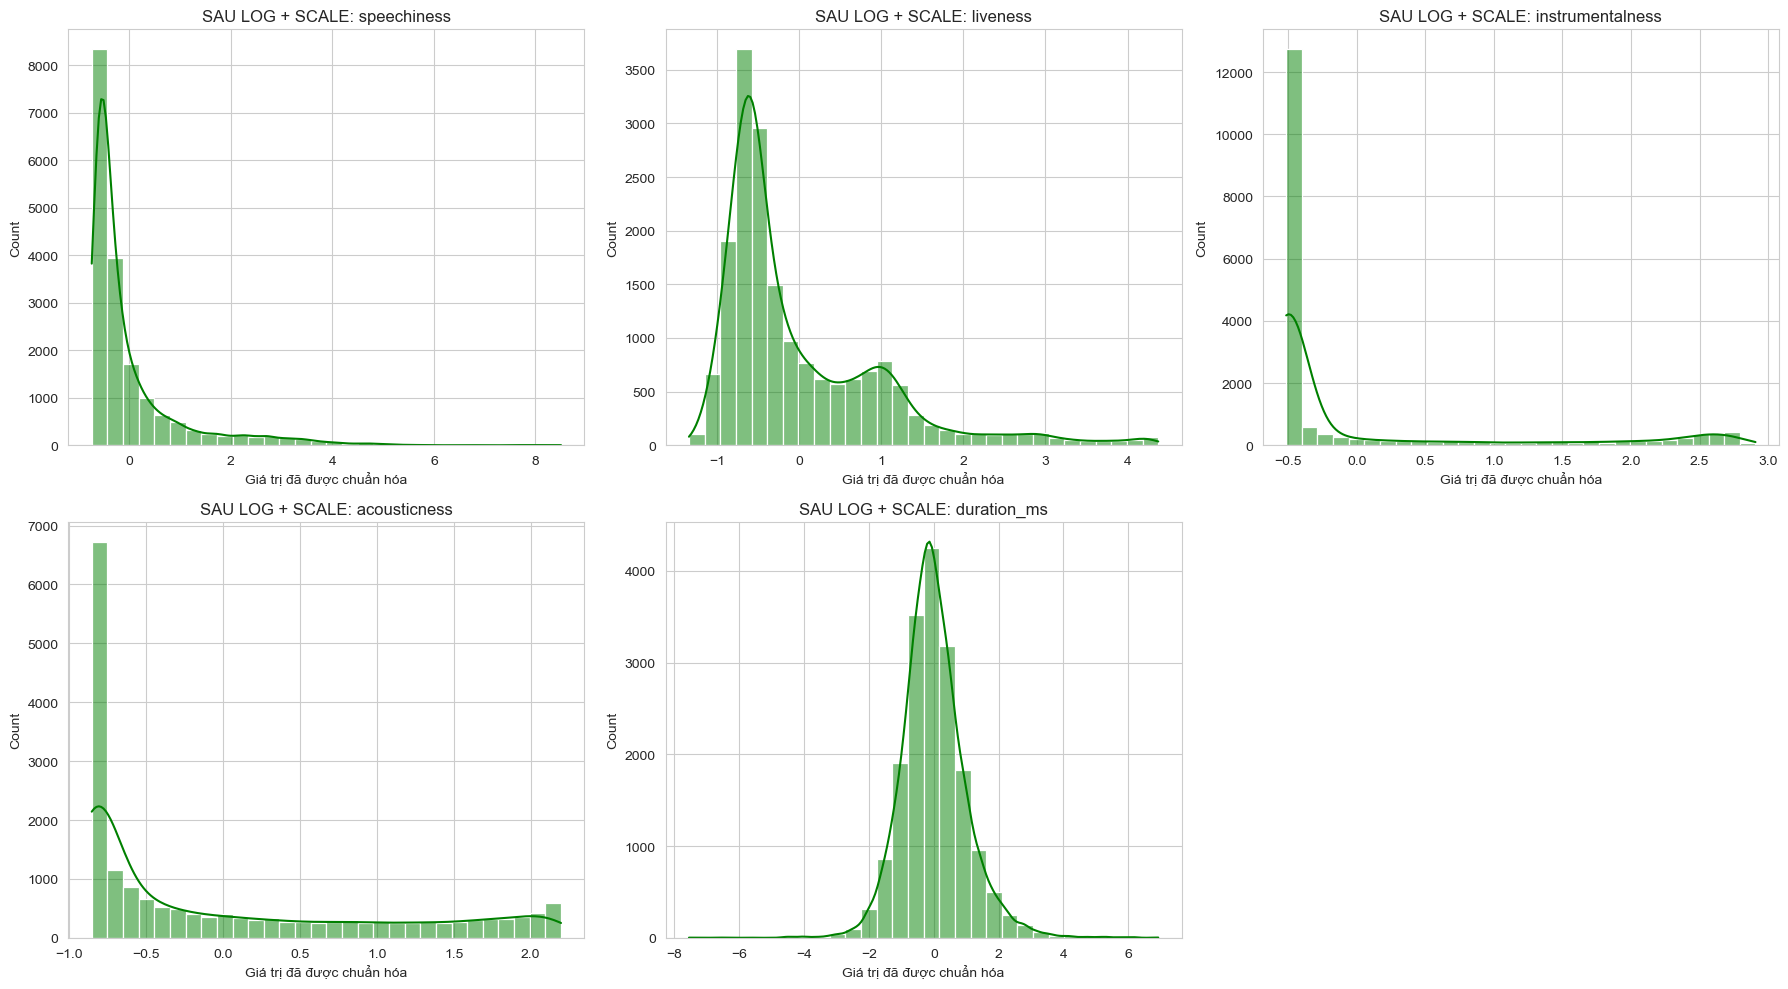

Trực quan hóa Phân phối sau Log Transform và Scaling hoàn tất.

Quá trình Tiền xử lý và Kỹ thuật Đặc trưng đã hoàn tất!


In [15]:
# Cell 6: Trực quan hóa Phân phối (Sau Biến đổi Log và Scaling)

# Sử dụng tên cột chính xác với tiền tố 'log_num__'
SKEWED_COLS_PROCESSED = [
    'log_num__speechiness', 
    'log_num__liveness', 
    'log_num__instrumentalness', 
    'log_num__acousticness', 
    'log_num__duration_ms'
]

# Kiểm tra đảm bảo các cột tồn tại trước khi vẽ
if all(col in X_processed_df.columns for col in SKEWED_COLS_PROCESSED):
    plt.figure(figsize=(18, 10))
    for i, col in enumerate(SKEWED_COLS_PROCESSED):
        plt.subplot(2, 3, i + 1)
        sns.histplot(X_processed_df[col], kde=True, bins=30, color='green')
        # Lấy tên gốc bằng cách loại bỏ tiền tố
        plt.title(f'SAU LOG + SCALE: {col.split("__")[-1]}', fontsize=12) 
        plt.xlabel('Giá trị đã được chuẩn hóa', fontsize=10)
        
    plt.tight_layout()
    plt.savefig('./doc/fig/distribution_after_log.png')
    plt.show()
    print("Trực quan hóa Phân phối sau Log Transform và Scaling hoàn tất.")
else:
    print("Lỗi: Không tìm thấy tên cột chính xác. Vui lòng kiểm tra lại tiền tố ColumnTransformer.")
    
print("\nQuá trình Tiền xử lý và Kỹ thuật Đặc trưng đã hoàn tất!")

### 4. Phân tích Phân phối SAU Biến đổi Log và Scaling

Biểu đồ **Histograms SAU LOG + SCALE** (Cell 6, `distribution_after_log.png`) cho thấy sự cải thiện rõ rệt:

- **Phân phối:** Các cột trước đây bị nghiêng mạnh (ví dụ: `log_num__speechiness`, `log_num__acousticness`) hiện đã có phân phối **đối xứng hơn** và **gần với phân phối chuẩn (Gaussian)**.
- **Chuẩn hóa:** Tất cả các giá trị số hiện đều tập trung xung quanh **0** và có độ lệch chuẩn là **1**, nhờ vào `StandardScaler`. Điều này là lý tưởng cho hầu hết các thuật toán Học máy.
- **Kích thước Dữ liệu:** Số lượng đặc trưng đã tăng lên (từ 16 lên [Hãy chèn kích thước cột thực tế từ output của bạn]) do việc mã hóa **One-Hot Encoding** cho các cột phân loại.

**Kết luận:** Tập dữ liệu đã được làm sạch, chuyển đổi và chuẩn hóa hoàn toàn. Tập dữ liệu cuối cùng (`X_train_processed`, `X_test_processed`) đã sẵn sàng để chuyển sang bước **Huấn luyện Mô hình**.